# NLE Assignment: Sentiment Classification

In this assignment, you will be investigating NLP methods for distinguishing positive and negative reviews written about movies.

For assessment, you are expected to complete and submit this notebook file.  When answers require code, you may import and use library functions (unless explicitly told otherwise).  All of your own code should be included in the notebook rather than imported from elsewhere.  Written answers should also be included in the notebook.  You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers.  If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data.   In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell.  Otherwise do not change the code in these cells.

In [2]:
candidateno=246529 #this MUST be updated to your candidate number so that you get a unique data sample


In [3]:
#do not change the code in this cell
#preliminary imports

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


In [4]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the 
            pair is a list of the training data and the second is a list of the test data.
    """
    
    data = list(data)  
    n = len(data)  
    train_indices = random.sample(range(n), int(n * ratio))          
    test_indices = list(set(range(n)) - set(train_indices))    
    train = [data[i] for i in train_indices]           
    test = [data[i] for i in test_indices]             
    return (train, test)                       
 

def get_train_test_data():
    
    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')
   
    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]
   
    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [5]:
#do not change the code in this cell
random.seed(candidateno)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['after', 'the', 'average', 'mouse', 'hunt', ',', ...], 'pos')


1)  
a) **Generate** a list of 10 content words which are representative of the positive reviews in your training data.

b) **Generate** a list of 10 content words which are representative of the negative reviews in your training data.

c) **Explain** what you have done and why

[20\%]

In [6]:
#normalise data by removing stopwords and converting all text to lowercase
stop = stopwords.words('english')
def normalise(wordlist):
    lowered=[word.lower() for word in wordlist]
    filtered=[word for word in lowered if word.isalpha() and word not in stop]
    return filtered

training_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in training_data]
testing_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in testing_data]

#splits the normalised training data in to two freqdist's, one for negative and one for positive
pos_freq_dist=FreqDist()
neg_freq_dist=FreqDist()

for reviewDist,label in training_norm:
    if label=='pos':
        pos_freq_dist+=reviewDist
    else:
        neg_freq_dist+=reviewDist

#gets the most commonly occuring words in the freqdist
def most_frequent_words(posfreq,negfreq,topk):
    difference=posfreq-negfreq
    sorteddiff=difference.most_common()
    justwords=[word for (word,freq) in sorteddiff[:topk]]
    return justwords

#assign variables as a list of the 10 most commonly occuring content words in data for both positive and negative reviews
pos_words = most_frequent_words(pos_freq_dist, neg_freq_dist, 10)
neg_words = most_frequent_words(neg_freq_dist, pos_freq_dist, 10)

In [7]:
pos_words

['film',
 'life',
 'story',
 'great',
 'also',
 'well',
 'best',
 'world',
 'films',
 'many']

In [8]:
neg_words

['movie',
 'bad',
 'plot',
 'even',
 'script',
 'get',
 'worst',
 'nothing',
 'could',
 'better']

Firstly, I have normalised the whole of 'training_data' by taking out all the stop words and making every word lower case and stored it in a new list called 'training_norm'. Next, I seperated the data by the positve and negative reviews in a FreqDist which gives the number of occurences of each word in the data. Finally, I chose to take the ten most frequent content words in the data for both positive and negative reviews.


2) 
a) **Use** the lists generated in Q1 to build a **word list classifier** which will classify reviews as being positive or negative.

b) **Explain** what you have done.

[12.5\%]


In [9]:
class SimpleClassifier(ClassifierI): 

    def __init__(self, pos, neg): 
        self._pos = pos 
        self._neg = neg 

    def classify(self, doc): 
        #doc is a FreqDist
        score = 0
        
        #assigns a value to score
        for word,value in doc.items():
            if word in self._pos:
                score+=value
            if word in self._neg:
                score-=value
        
        #if the score is less than 0 it returns negative, and anything else is positive
        return "neg" if score < 0 else "pos"

    def labels(self): 
        return ("pos", "neg")

#creates the word list classifier to be tested on example sentences as shown below which uses the lists created in Q1
classifier = SimpleClassifier(pos_words, neg_words)
classifier.classify(FreqDist("The movie was incredible".split()))

'neg'

In [10]:
#assigned an increased list of content words to make the classifer more accurate
pos_words = most_frequent_words(pos_freq_dist, neg_freq_dist, 1000)
neg_words = most_frequent_words(neg_freq_dist, pos_freq_dist, 1000)

classifier = SimpleClassifier(pos_words, neg_words)
classifier.classify(FreqDist("The movie was incredible".split()))

'pos'

A list of positive words and a list of negative words are used to initialise the classifier. The classify method takes the words in a document where each instance of a bad word should result in a score reduction, and each instance of a positive word should result in a score increase. At first I used the same list of words I created in Q1 to use on my classifer however recived mixed results with the accuracy as shown above the classifier thinks 'The movie was incredible' is a negative review but when I increased the size of the word lists to 1000, it was more able to differentiate between negative and positve reviews.

The scoring I used for the classify method is very simple and it is easy to see why with a small sample size the method can somtimes get it wrong. That being said the performance of my classifer would be linear because as the sample size grows, the accuracy of the classifier grows directly proportionate to it.

3)
a) **Calculate** the accuracy, precision, recall and F1 score of your classifier.

b) Is it reasonable to evaluate the classifier in terms of its accuracy?  **Explain** your answer and give a counter-example (a scenario where it would / would not be reasonable to evaluate the classifier in terms of its accuracy).

[20\%]

In [ ]:
class ConfusionMatrix:
    #aggregates the predictions and goldstandard in a tuple to construct the confusion matrix
    def __init__(self,predictions,goldstandard,classes=("pos","neg")):
        (self.c1,self.c2)=classes
        #self.predictions=predictions
        self.TP=0
        self.FP=0
        self.FN=0
        self.TN=0
        for p,g in zip(predictions,goldstandard):
            if g==self.c1:
                if p==self.c1:
                    self.TP+=1
                else:
                    self.FN+=1
        
            elif p==self.c1:
                self.FP+=1
            else:
                self.TN+=1
    
    #below are the methods which compute the accuracy, recall, precision and f1 of data
    def accuracy(self):
      self.N=self.TP+self.TN+self.FP+self.FN

      a=0

      a=(self.TP+self.TN) / self.N

      return a 
        
    
    def precision(self):
        p=0
        p = self.TP / (self.TP + self.FP)
    
        return p
  
    def recall(self):
        r=0
        r = self.TP / (self.TP + self.FN)
    
        return r
  
    def f1(self):
        f1=0
        p=self.precision()
        r=self.recall()
        f1=2*p*r/(p+r)
        return f1 

In [ ]:
#tests the methods on data
docs1,labels=zip(*testing_norm)
myconfusionmatrix=ConfusionMatrix(classifier.classify_many(docs1), labels)
print(myconfusionmatrix.recall())
print(myconfusionmatrix.precision())
print(myconfusionmatrix.accuracy())
print(myconfusionmatrix.f1())

0.98
0.5675675675675675
0.6166666666666667
0.7188264058679706


I have decided to use a confusion matrix to calculate the accuracy, precision, recall and f1 of my classifier. This helps to visualise the performances by creating a 2x2 table with the predicted condition along with the actual condition. The init method computes the number of True Positives(TP), False Positives(FP), True Negatives(TN) and False Negatives(FN) which are needed to calculate the scores. Next, created methods which calculate the corresponding scores using their formulas and the actual and predicted conditions.

Accuracy is often a bad way to measure a classifier as it hides detail. For example when we have an imbalanced set of data. If our document containted 100 reviews of which 95 were positive and 5 were negative while we may achieve an accuracy of 95%, this is not a good score becuase our test data was unbalanced in the first place. On the other hand, if we can ensure a balanced set of data the classifier should be able to give higher performing results, or even with little imbalance still give results without masking the truth. This is why we use a confusion matrix as it helps to visualise the data.

4) 
a)  **Construct** a Naive Bayes classifier (e.g., from NLTK).

b)  **Compare** the performance of your word list classifier with the Naive Bayes classifier.  **Discuss** your results. 

[12.5\%]

In [ ]:
import math

class NBClassifier(ClassifierI):
    
    def __init__(self):
        
        pass
    
    #adds words from the training data to a new set of known vocab which the classifier can learn from
    def _set_known_vocabulary(self,training_data):
        known=[]
        for doc,label in training_data:
            known+=list(doc.keys())
        self.known= set(known)
    
    #takes a dictionary of training data and returns a dictionary that maps the name of each class to the class prior for that class
    def _set_priors(self,training_data):
        priors={}
        for (doc,label) in training_data:
            priors[label]=priors.get(label,0)+1
        total=sum(priors.values())
        for key,value in priors.items():
            priors[key]=value/total
        self.priors=priors

    #takes training data and returns a dictionary that maps the name of a class onto a dictionary that maps each word, to the conditional probability for that word given that class i.e. P(word|class)  
    def _set_cond_probs(self,training_data):       
        conds={}
        for(doc,label) in training_data:
            classcond=conds.get(label,{})
            for word in doc.keys():
                classcond[word]=classcond.get(word,0)+1
        
            conds[label]=classcond
    
        for label, classcond in conds.items():
            for word in self.known:
        
                classcond[word]=classcond.get(word,0)+1
            conds[label]=classcond
            
        for label,dist in conds.items():
            total=sum(dist.values())
            conds[label]={key:value/total for (key,value) in dist.items()}
        
        self.conds=conds
    
    #trains the NB classifier on fundemental preliminaries defined above
    def train(self,training_data):
        self._set_known_vocabulary(training_data)
        self._set_priors(training_data)
        self._set_cond_probs(training_data)
    
    #returns the class that the classifier assigns to the document(doc)
    #if theres a tie, it randomly chooses one of the classes
    def classify(self,doc):
        doc_probs={key:math.log(value) for (key,value) in self.priors.items()}
        for word in doc.keys():
            if word in self.known:
                doc_probs={classlabel:sofar+math.log(self.conds[classlabel].get(word,0)) for (classlabel,sofar) in doc_probs.items()}

        highprob=max(doc_probs.values())
        classes=[c for c in doc_probs.keys() if doc_probs[c]==highprob]
        return random.choice(classes)

In [ ]:
#created two lists to test the NB classifier on
pos_test = [
    "this movie is amazing",
    "this movie is really good",
    "i really enjoyed this film"
]
neg_test = [
    "this movie was bad",
    "the film was terrible",
    "i hated this movie"
]
#specifies whether each sentence is positive or negative
pos_freq_test = [(FreqDist(sent.split()), "pos") for sent in pos_test]
neg_freq_test = [(FreqDist(sent.split()), "neg") for sent in neg_test]
test_freq_data = pos_freq_test+neg_freq_test


#trains classifier using training data and tests on above sentences
#returns whether it thinks the sentence is positive or negative
myclassifier=NBClassifier()
myclassifier.train(training_norm)
myclassifier.classify_many(doc for (doc,label) in test_freq_data)

['pos', 'neg', 'pos', 'neg', 'neg', 'neg']

My Naive Bayes classifer has three preliminaries; known vocab, priors and conditional probabilities. Firstly, known vocab these are the words that the classifier can learn somthing about. If a document contains any terms that are not part of the recognised vocabulary and the classifier is requested to classify it, it will just ignore those words. Secondly we have the priors. The priors in our case is essentially the probability, P of our positive and negative reviews (P(positive), P(negative)) and learns these from the 'training_data' provided. Finally we have the conditional probabilities. This method calculates the probability of some document d, occuring in our seperate reviews. An issue may arise where we may not have seen d in the training data and to address this, it makes a major simplifying assumption.

As seen above, the data I have used to test the NB classifier on returned a mostly correct outcome, with the exeption of 1 positive review being classified as negative. This may be because our training_data is not large enough however is still fairly accurate with its predictions. As discussed before, the performance of the word list classifier is directly proportionate to the size of words it is trained on which is able to achieve good results given its trained on a sufficiently large set of data. This could be an issue if this does not exist, where we can say the NB classifier performs better than other models with less training data if our assumptions of independence of features holds. However, the NB classifier will give zero probability and won't be able to make any predictions if your test data set contains a variable of a category that wasn't included in the training data. The main disadvantage of the NB model is that it assumes all features are independent which can hinder the performance.

5) 
a) Design and **carry out an experiment** into the impact of the **length of the wordlists** on the wordlist classifier.  Make sure you **describe** design decisions in your experiment, include a **graph** of your results and **discuss** your conclusions. 

b) Would you **recommend** a wordlist classifier or a Naive Bayes classifier for future work in this area?  **Justify** your answer.

[25\%]


In [ ]:
#derives wordlist by most frequent and creates new classifier
class SimpleClassifier_mf(SimpleClassifier):
    
    def __init__(self,k):
        self._k=k
    
    def train(self,training_data):
        
        pos_freq_dist=FreqDist()
        neg_freq_dist=FreqDist()

        for reviewDist,label in training_data:
            if label=='pos':
                pos_freq_dist+=reviewDist
            else:
                neg_freq_dist+=reviewDist
                
        self._pos=most_frequent_words(pos_freq_dist,neg_freq_dist,self._k)
        self._neg=most_frequent_words(neg_freq_dist,pos_freq_dist,self._k)

Above I have defined a new classifer which derives wordlists from the training data by most frequent, which was used in Q1.

In [ ]:
from random import sample

#the classifiers used for each sample
classifiers={"Wordlist 2":SimpleClassifier_mf(2),
             "Wordlist 20":SimpleClassifier_mf(20),
             "Wordlist 200":SimpleClassifier_mf(200)}

#sample sizes and sets to store them in
sample_sizes=[2,20,200]
results1={}
results2={}
results3={}
results4={}

number_of_runs = 3

#method to calculate the accuracy, recall, precision and f1. parameter 'measure' is the data you want to recieve
def create_data(measure):
  for size in sample_sizes:
    res={}

    for i in range(number_of_runs):
        #generates a different sample for each run to get different results
        docs,labels=zip(*testing_norm)
        positive_training=[(doc,label) for (doc,label) in training_norm if label=="pos"]
        negative_training=[(doc,label) for (doc,label) in training_norm if label=="neg"]
        training_sample=sample(positive_training,size)+sample(negative_training,size)
        for name,classifier in classifiers.items():

            #trains and creates a new confusion matrix to measure the data
            classifier.train(training_sample)
            cm_classifier=ConfusionMatrix(classifier.classify_many(docs), labels)
            
            #stores the average result of the number of runs for each different measure
            if measure == 'accuracy':
              accuracy=cm_classifier.accuracy()
              print("The accuracy of {} classifier with training sample size {} is {}".format(name,size, accuracy))
              res[name]=res.get(name,0)+accuracy/number_of_runs
              results1[size]=res
            elif measure == 'recall':
              recall=cm_classifier.recall()
              print("The recall of {} classifier with training sample size {} is {}".format(name,size, recall))
              res[name]=res.get(name,0)+recall/number_of_runs
              results2[size]=res
            elif measure == 'precision':
              precision=cm_classifier.precision()
              print("The precision of {} classifier with training sample size {} is {}".format(name,size, precision))
              res[name]=res.get(name,0)+precision/number_of_runs
              results3[size]=res
            elif measure == 'f1':
              f1=cm_classifier.f1()
              print("The f1 of {} classifier with training sample size {} is {}".format(name,size, f1))
              res[name]=res.get(name,0)+f1/number_of_runs
              results4[size]=res


The algorithm above is designed to produce data for the accuracy, precision, recall and f1 score of my wordlist classifier on different sample sizes/lengths of my wordlist. The experiment produces results on wordlist sizes of 2, 20 and 200 for sample sizes of the same values and on each run uses a new confusion matrix to create 3 scores for each sample size which it then stores the average of them, which increases the reliability of each score. This is demonstrated below.

In [ ]:
print(create_data('accuracy'))
print(create_data('precision'))
print(create_data('recall'))
print(create_data('f1'))

The accuracy of Wordlist 2 classifier with training sample size 2 is 0.515
The accuracy of Wordlist 20 classifier with training sample size 2 is 0.5316666666666666
The accuracy of Wordlist 200 classifier with training sample size 2 is 0.515
The accuracy of Wordlist 2 classifier with training sample size 2 is 0.49833333333333335
The accuracy of Wordlist 20 classifier with training sample size 2 is 0.51
The accuracy of Wordlist 200 classifier with training sample size 2 is 0.5016666666666667
The accuracy of Wordlist 2 classifier with training sample size 2 is 0.5066666666666667
The accuracy of Wordlist 20 classifier with training sample size 2 is 0.56
The accuracy of Wordlist 200 classifier with training sample size 2 is 0.53
The accuracy of Wordlist 2 classifier with training sample size 20 is 0.5566666666666666
The accuracy of Wordlist 20 classifier with training sample size 20 is 0.575
The accuracy of Wordlist 200 classifier with training sample size 20 is 0.6366666666666667
The accur

In [ ]:
#generates tables for viewing the data
df1=pd.DataFrame(results1)
df1=df1.transpose()
display(df1)

df2=pd.DataFrame(results2)
df2=df2.transpose()
display(df2)

df3=pd.DataFrame(results3)
df3=df3.transpose()
display(df3)

df4=pd.DataFrame(results4)
df4=df4.transpose()
display(df4)

,Wordlist 2,Wordlist 20,Wordlist 200
2,0.506667,0.533889,0.515556
20,0.538333,0.535000,0.559444
200,0.593889,0.643333,0.643889


,Wordlist 2,Wordlist 20,Wordlist 200
2,0.894444,0.816667,0.867778
20,0.408889,0.468889,0.477778
200,0.704444,0.912222,0.950000


,Wordlist 2,Wordlist 20,Wordlist 200
2,0.499837,0.504993,0.529947
20,0.496104,0.554324,0.571317
200,0.552028,0.572196,0.552305


,Wordlist 2,Wordlist 20,Wordlist 200
2,0.577465,0.486833,0.500109
20,0.483039,0.569323,0.658566
200,0.658055,0.708731,0.716948


Text(0.5, 0, 'Sample Size')

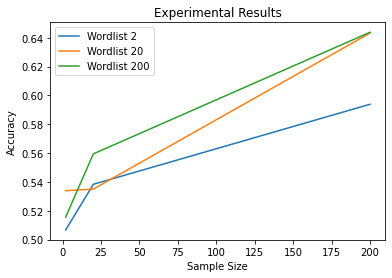

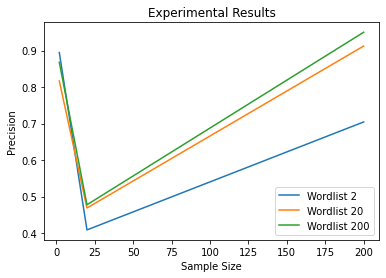

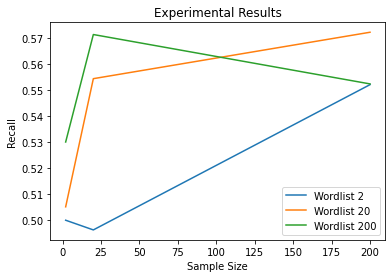

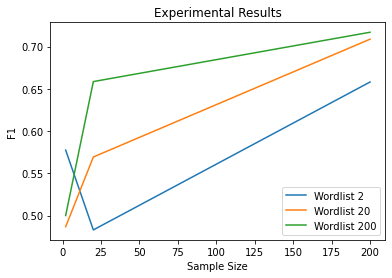

In [ ]:
#plots the data shown above in line graphs
ax = df1.plot(kind="line",title="Experimental Results")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Sample Size")

ax = df2.plot(kind="line",title="Experimental Results")
ax.set_ylabel("Precision")
ax.set_xlabel("Sample Size")

ax = df3.plot(kind="line",title="Experimental Results")
ax.set_ylabel("Recall")
ax.set_xlabel("Sample Size")

ax = df4.plot(kind="line",title="Experimental Results")
ax.set_ylabel("F1")
ax.set_xlabel("Sample Size")

The data calculated above shown in both table format and graph format shows varying results with each sample size calculated. In all the graphs, it is clear to see that with a increased wordlist size (20 and 200) the reliability of the results are much better. Furthermore, it is also clear to see that as the sample size increases as does the reliability.

1. Accuracy
The accuracy graph has very similar results between the different wordlist sizes. This indicates either accuracy is good at dealing with wordlists of smaller sizes or could be a further issue concerning the reliability of accuracy as discussed previously. The highest the accuracy goes with the largest wordlist size is 0.64 which is average compared to the other graphs.

2. Precision
This graph has the most similar results in regard to how the precision grows with different sample sizes and also the wordlist sizes. This highlights the reliability of precision and produces very good results the highest being over 0.9. However one thing that stands out is at the very start it has a very high value, which is likely a false outcome as it very quickly decreases from the start.

3. Recall
This graph has the most outlandish results with none of the graphs having similar growths. This could be due to the fact that recall is based on relevance and could not find the fraction of relevant instances. This is further highlighted by the fact that wordlist 20 actually has the best final result with a score of 0.57, which is the worst of all the graphs.

4. F1
This graph also has very consistent results that grow as we'd expect and also finishes with high overall scores, with wordlist 200 having a score of 0.7. As it is a combination of precision and recall, it covers more data and samples which increases its reliability a lot. However as discussed the recall results are not what is expected and therefore may skew the overall reliabilty of F1

5. Overall
Comparing each of the graphs and discussions about their results I would choose precision as the best way of measuring a wordlist classifier. It produces the most consistent results and gives the highest overall scores.

6. Naive Bayes vs Wordlist classifiers
I would reccomend a NB classifier for future work in this area. This is because over all samples of training data it consistently outperforms a wordlist classifier, especially with a low amount of training data, as discussed in Q4. It achieves this by providing better grading performance by eliminating insignificant specifications. Furthermore, the NB classifier is easy to implement and much faster than a wordlist classifier which is often prefered over higher accuracy.

In [13]:
##This code will word count all of the markdown cells in the notebook saved at filepath
##Running it before providing any answers shows that the questions have a word count of 437
from google.colab import drive
drive.mount('/content/drive')

import io
from nbformat import current

filepath="/content/drive/My Drive/NLE notebooks/coursework/NLassignment2022.ipynb"
# filepath="NLassignment2022.ipynb"
question_count=437

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Submission length is 1277
